In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

import sklearn.neighbors as neighbors
from sklearn.neighbors import KNeighborsClassifier


In [19]:
df = pd.read_csv('train.csv')

In [20]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:

df.shape

(891, 12)

In [22]:
# Percentage of missing values in dataframe
df.isnull().sum().sort_values(ascending=False)
(df.isnull().sum()/df.isnull().sum().count()).sort_values(ascending=False)

Cabin          57.250000
Age            14.750000
Embarked        0.166667
Fare            0.000000
Ticket          0.000000
Parch           0.000000
SibSp           0.000000
Sex             0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
PassengerId     0.000000
dtype: float64

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


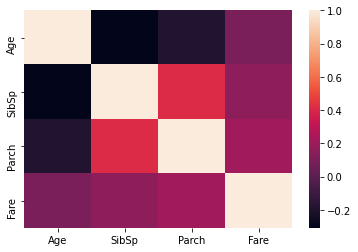

In [23]:
# numeric and cateogrical variables
df_num = df[['Age','SibSp','Parch', 'Fare']]
df_cat = df[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

# # correlation
print(df_num.corr())
sns.heatmap(df_num.corr())

In [24]:
# survival rate of Age Age,SibSp,Parch,Fare
pd.pivot_table(df, index='Survived', values=['Age','SibSp','Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


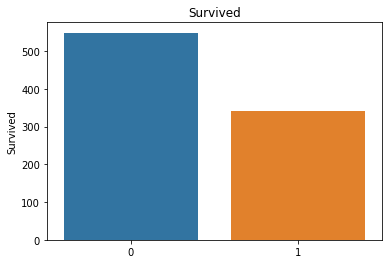

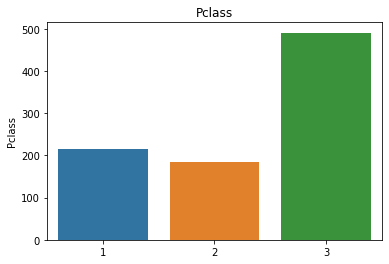

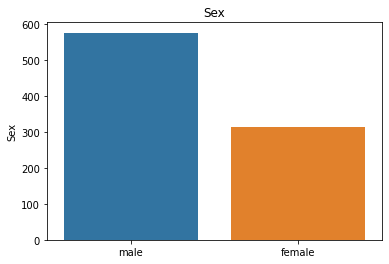

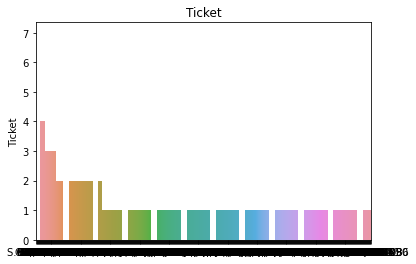

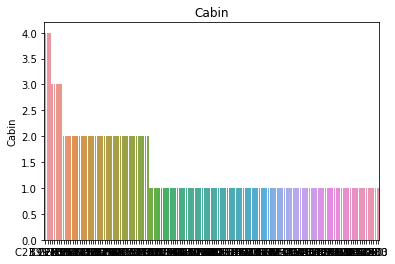

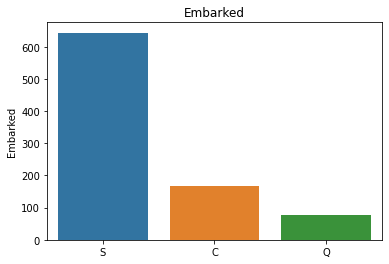

In [32]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index, df_cat[i].value_counts()).set_title(i)
    plt.show()

In [39]:
# Comparing survived by each category
pd.pivot_table(df, index = 'Survived', columns= 'Sex', values= 'Ticket', aggfunc= 'count')
pd.pivot_table(df, index = 'Survived', columns= 'Pclass', values= 'Ticket', aggfunc= 'count')
pd.pivot_table(df, index = 'Survived', columns= 'Embarked', values= 'Ticket', aggfunc= 'count')


Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


# Data  Clean and Preprocessing

In [242]:
# Split the Name column from suffix Names
df = pd.read_csv('/kaggle/input/titanic/train.csv')

suffix_Name= df['Name'].str.replace(r'[^\w\s]+','')
suffix_Name= df['Name'].str.split(expand= True)

# Combine suffix Name to data frame
df = pd.concat([df,suffix_Name],axis=1)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,4,5,6,7,8,9,10,11,12,13
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,None,None,None,None,None,None,None,None,None,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,(Florence,Briggs,Thayer),None,None,None,None,None,None,None
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,None,None,None,None,None,None,None,None,None,None
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,(Lily,May,Peel),None,None,None,None,None,None,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,None,None,None,None,None,None,None,None,None,None


In [243]:
# # Del observations without Embarked and getting index where it is null
# df.drop(df[pd.isnull(df['Embarked'])].index, inplace=True) 
# df[pd.isnull(df['Embarked'])]

In [244]:
# Drop Cabin
#df.drop('Cabin', axis=1, inplace=True)
df.drop(columns=['PassengerId','Cabin'], axis=1, inplace=True)

In [245]:
# (Snippet) Replacing missing values using the mean value of the columns that contain the missing values
age_imputer = SimpleImputer(strategy='median')
df['Age'] = age_imputer.fit_transform(df.loc[:,['Age']])
df['Age'].head()


0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [246]:
df['Embarked']=df['Embarked'].fillna(method='bfill')
df['Embarked'].count()

891

In [247]:
# Rename column suffix name  as title
df.rename(columns={1:'Title'}, inplace=True)

In [248]:
# remove leaky columns
#del df['Name']
#del df[0]
df.drop(columns=['Name',13,12,11,10,9,8,7,6,5,4,3,2,0], axis=1, inplace=True)


In [249]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr.
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,1,1,female,35.0,1,0,113803,53.1000,S,Mrs.
4,0,3,male,35.0,0,0,373450,8.0500,S,Mr.


In [250]:
# Label encode the variables
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder 

d = defaultdict(LabelEncoder)
#With this, you now retain all columns LabelEncoder as dictionary.

training_data = df.apply(lambda x: d[x.name].fit_transform(x))
training_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,2,1,28,1,0,523,18,2,17
1,1,0,0,51,1,0,596,207,0,18
2,1,2,0,34,0,0,669,41,2,14
3,1,0,0,47,1,0,49,189,2,18
4,0,2,1,47,0,0,472,43,2,17
...,...,...,...,...,...,...,...,...,...,...
886,0,1,1,35,0,0,101,85,2,23
887,1,0,0,24,0,0,14,153,2,14
888,0,2,0,36,1,2,675,131,2,14
889,1,0,1,34,0,0,8,153,0,17


In [251]:
# test train split
y = training_data.Survived
X = training_data.drop(columns='Survived')

# Spitting data in two here is our model is learining patterns that will extend to novel patterns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [252]:
training_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,2,1,28,1,0,523,18,2,17
1,1,0,0,51,1,0,596,207,0,18
2,1,2,0,34,0,0,669,41,2,14
3,1,0,0,47,1,0,49,189,2,18
4,0,2,1,47,0,0,472,43,2,17


# XGBoost

In [262]:

# Convert to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#num_class = y.nunique()

In [263]:
# train model
param = {'objective':'multi:softmax', 'num_class': 6, 'max_depth': 10}
watchlist = [(dtrain, 'train'), (dtest, 'test')]

num_round = 10
bst = xgb.train(param, dtrain, num_round,watchlist)

[0]	train-merror:0.10612	test-merror:0.16667
[1]	train-merror:0.08864	test-merror:0.21111
[2]	train-merror:0.08364	test-merror:0.20000
[3]	train-merror:0.07366	test-merror:0.18889
[4]	train-merror:0.07116	test-merror:0.16667
[5]	train-merror:0.06742	test-merror:0.18889
[6]	train-merror:0.06242	test-merror:0.18889
[7]	train-merror:0.05868	test-merror:0.16667
[8]	train-merror:0.05119	test-merror:0.16667
[9]	train-merror:0.04619	test-merror:0.17778


In [264]:
# get prediction
pred = bst.predict(dtest)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))

Test error using softmax = 0.17777777777777778


In [265]:
# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
num_round = 15
bst_prob = xgb.train(param, dtrain, num_round, watchlist)


[0]	train-merror:0.10612	test-merror:0.16667
[1]	train-merror:0.08864	test-merror:0.21111
[2]	train-merror:0.08364	test-merror:0.20000
[3]	train-merror:0.07366	test-merror:0.18889
[4]	train-merror:0.07116	test-merror:0.16667
[5]	train-merror:0.06742	test-merror:0.18889
[6]	train-merror:0.06242	test-merror:0.18889
[7]	train-merror:0.05868	test-merror:0.16667
[8]	train-merror:0.05119	test-merror:0.16667
[9]	train-merror:0.04619	test-merror:0.17778
[10]	train-merror:0.04120	test-merror:0.17778
[11]	train-merror:0.03745	test-merror:0.18889
[12]	train-merror:0.03371	test-merror:0.18889
[13]	train-merror:0.03246	test-merror:0.17778
[14]	train-merror:0.03246	test-merror:0.18889


In [266]:
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst_prob.predict(dtest).reshape(y_test.shape[0],6)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_test) / y_test.shape[0]
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.18888888888888888


In [267]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.11%


# Cross validation (KFlod)

accuracy of a linear 'kernel'(we cahnge to 'rbf','poly','sigmoid') support vector machine on dataset by splitting the data, fitting a model 
and computing the score 10 consecutive times

In [268]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

X_train.shape, y_train.shape
X_test.shape, y_test.shape

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)
scores = cross_val_score(clf, X, y, cv=10)
scores

array([0.81111111, 0.79775281, 0.76404494, 0.84269663, 0.79775281,
       0.7752809 , 0.76404494, 0.74157303, 0.80898876, 0.76404494])

CV iteration is the score method estimator,possible to change this by using the scoring parameter

In [269]:
from sklearn import metrics
scores = cross_val_score(
clf, X, y, cv=10, scoring='f1_macro')
scores

array([0.80023502, 0.78582888, 0.74202899, 0.83518519, 0.78809524,
       0.75250278, 0.74202899, 0.71318481, 0.79116632, 0.74868899])

# KNN

In [270]:
import sklearn.neighbors as neighbors
from sklearn.neighbors import KNeighborsClassifier
# neighbors.BallTree

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

In [272]:

pred_label = neigh.predict(X_test)
error_rate = np.sum(pred_label != y_test) / y_test.shape[0]

print(error_rate)

0.28888888888888886


In [273]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.11%
